<a href="https://colab.research.google.com/github/alawrence30/Machine-Learning/blob/main/Week_3_Discussion_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### NLTK Downloads

In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [ ]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [ ]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Utility Functions

In [ ]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, interstellar_doc_ids: List[int], sci_fi_doc_ids: List[int]):
    data['is_interstellar'] = data.index.isin(interstellar_doc_ids)
    data['is_sci_fi'] = data.index.isin(sci_fi_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the corpus

In [ ]:
work_dir = "/content/gdrive/My Drive/MSDS 453/Week 2/Assignment 1/"
corpus_df = get_corpus_df(work_dir + 'ClassCorpus_v2.csv')
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploratory Data Analysis

In [ ]:
corpus_df.shape

(200, 8)

In [ ]:
corpus_df.head().T

Doc_ID,191,192,193,194,195
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale,JLU_Doc4_JamesBondCasinoRoyale,JLU_Doc5_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU,JLU,JLU
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...,The introduction of a new James Bond always br...,Although box office has remained strong worldw...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193","Action_James Bond, Casino Royale_N_194","Action_James Bond, Casino Royale_N_195"
Doc_ID,191,192,193,194,195


In [ ]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 191 to 75
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Student Name              200 non-null    object
 2   Genre of Movie            200 non-null    object
 3   Review Type (pos or neg)  200 non-null    object
 4   Movie Title               200 non-null    object
 5   Text                      200 non-null    object
 6   Descriptor                200 non-null    object
 7   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 14.1+ KB
None


## Number of Reviews By Genre

In [ ]:
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Action,40
1,Comedy,60
2,Horror,50
3,Sci-Fi,50


In [ ]:
corpus_df.columns

Index(['DSI_Title', 'Student Name', 'Genre of Movie',
       'Review Type (pos or neg)', 'Movie Title', 'Text', 'Descriptor',
       'Doc_ID'],
      dtype='object')

## Standardize Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [ ]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=191, text='is this where we are at is this the state of the nation bring back the cold war and let s dump this bond into the rubbish bin of america s world paranoia because that s whets happened bond has been hijacked by the yankee doodle dandy with a cob on in every bond from on her majesty s secret service to golden eye there has been more than a passing nod in the direction of the fleming novels and although the plot of the film sticks tersely to the novels outline its modern interpretation is like fitting a square peg into a round hole craig s bond is the proverbial hammer for whom every problem seems to be a nail this was a real chance to expose an audience to flemings insight into the bond character his reasons for returning to the service are complicated and full of pathos made all the more acute by vespers suicide now i m not one of those nuts that says a film should be like the book not in the least they are two distinct and separate forms and should do what th

## Tokenized Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [ ]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=191, tokens=['is', 'this', 'where', 'we', 'are', 'at', 'is', 'this', 'the', 'state', 'of', 'the', 'nation', 'bring', 'back', 'the', 'cold', 'war', 'and', 'let', 's', 'dump', 'this', 'bond', 'into', 'the', 'rubbish', 'bin', 'of', 'america', 's', 'world', 'paranoia', 'because', 'that', 's', 'whets', 'happened', 'bond', 'has', 'been', 'hijacked', 'by', 'the', 'yankee', 'doodle', 'dandy', 'with', 'a', 'cob', 'on', 'in', 'every', 'bond', 'from', 'on', 'her', 'majesty', 's', 'secret', 'service', 'to', 'golden', 'eye', 'there', 'has', 'been', 'more', 'than', 'a', 'passing', 'nod', 'in', 'the', 'direction', 'of', 'the', 'fleming', 'novels', 'and', 'although', 'the', 'plot', 'of', 'the', 'film', 'sticks', 'tersely', 'to', 'the', 'novels', 'outline', 'its', 'modern', 'interpretation', 'is', 'like', 'fitting', 'a', 'square', 'peg', 'into', 'a', 'round', 'hole', 'craig', 's', 'bond', 'is', 'the', 'proverbial', 'hammer', 'for', 'whom', 'every', 'problem', 'seems', 'to', 'be

## Useful Lookups (Titles by DocID, Genres by DocID, Description by DocID)

In [ ]:
titles_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Movie Title'])}
genres_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Genre of Movie'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Descriptor'])}

sci_fi_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] == 'Sci-Fi']
sci_fi_documents = [x for x in documents if x.doc_id in sci_fi_doc_ids]

non_sci_fi_doc_ids = {int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] != 'Sci-Fi'}
non_sci_fi_documents = [x for x in documents if x.doc_id in non_sci_fi_doc_ids]

## Lookup for Specific Movie Title

In [ ]:
print(corpus_df['Movie Title'].unique())

['James Bond, Casino Royale' 'Mission Impossible Fallout'
 'Pirates of the Caribbean: The Curse of the Black Pearl' 'Speed Racer'
 'Cruella' 'Encanto' 'Frozen II' 'Red Notice' 'Spider Man 3'
 'The Grand Budapest Hotel' 'Hereditary' 'Lamb' 'The Conjuring 3'
 'The Ring' 'Us' 'Arrival' 'Guardians of the Galaxy' 'Interstellar'
 'The Martian' 'The Matrix Resurrections']


In [ ]:
interstellar_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if titles_by_doc_ids[x] == 'Interstellar']
interstellar_documents = [x for x in documents if x.doc_id in interstellar_doc_ids]

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

In [ ]:
candidate_terms = [
    'film',
    'life',
    'movie',
    'science',
    'earth',
    'future',
    'explore',
    'astronaut',
    'pilot',
    'gravity',
    'future',
    'space',
    'moon',
    'universe'
]

## CountVectorizer

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br> 
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.Doc_ID)

In [ ]:
add_flags(word_counts, interstellar_doc_ids, sci_fi_doc_ids)
word_counts['Doc_ID'] = word_counts.index

In [ ]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame(index=candidate_terms)

interstellar_mean_frequencies = word_counts[word_counts.is_interstellar][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Interstellar'] = interstellar_mean_frequencies

sci_fi_mean_frequencies = word_counts[word_counts.is_sci_fi][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Sci-Fi'] = sci_fi_mean_frequencies

non_sci_fi_mean_frequencies = word_counts[~word_counts.is_sci_fi][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Non-Sci-Fi'] = non_sci_fi_mean_frequencies

In [ ]:
mean_frequencies.fillna(0.0).sort_values(['Interstellar'], ascending=False)

,Interstellar,All Sci-Fi,All Non-Sci-Fi
space,4.40,1.64,0.11
film,3.60,3.24,4.55
movie,3.50,3.02,3.03
earth,3.50,1.30,0.10
future,1.40,0.52,0.13
future,1.40,0.52,0.13
science,1.20,1.36,0.02
pilot,1.20,0.24,0.00
gravity,1.00,0.50,0.03
life,0.90,0.80,0.75


NameError: ignored

In [ ]:
# These are identified
important_prevalent_terms = [
    'space',
    'film',
    'movie',
    'earth',
]
stemmer = PorterStemmer()
stemmed_important_prevalent_terms = [stemmer.stem(x) for x in important_prevalent_terms]

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
mean_frequencies.fillna(0.0).loc[important_prevalent_terms].round(2).sort_values(['Interstellar'], ascending=False)

,Interstellar,All Sci-Fi,All Non-Sci-Fi
space,4.40,1.64,0.11
film,3.60,3.24,4.55
movie,3.50,3.02,3.03
earth,3.50,1.30,0.10


## TF-IDF Experiment Functions - Text Normalization

In [ ]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]
    
    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')
    
    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix, 
                               columns=vectorizer.get_feature_names_out(), 
                               index=corpus_df.Doc_ID)
    add_flags(doc_term_df, interstellar_doc_ids, sci_fi_doc_ids)
    
    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)
    
    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)
 
    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Movies'] = all_tfidf_results
    
    plt.hist(doc_term_df.mean(), 100, range=(0, 8))
    
    print(f'Vocabulary size: {doc_term_df.shape[1]}')
    
    descriptors = corpus_df['Descriptor']
       
    similarities = cosine_similarity(doc_term_df.loc[sci_fi_doc_ids], doc_term_df.loc[sci_fi_doc_ids])
    fig, ax = plt.subplots(figsize=(30, 30))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in sci_fi_documents]
    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

In [ ]:
def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)
        
    return documents

,Mean TF-IDF
film,5.78
bond,4.70
movi,4.66
cruella,3.87
one,3.56
wa,3.31
like,3.21
ha,3.11
anderson,2.48
charact,2.43


Vocabulary size: 10503


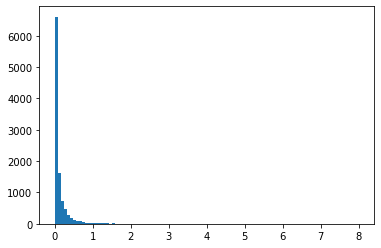

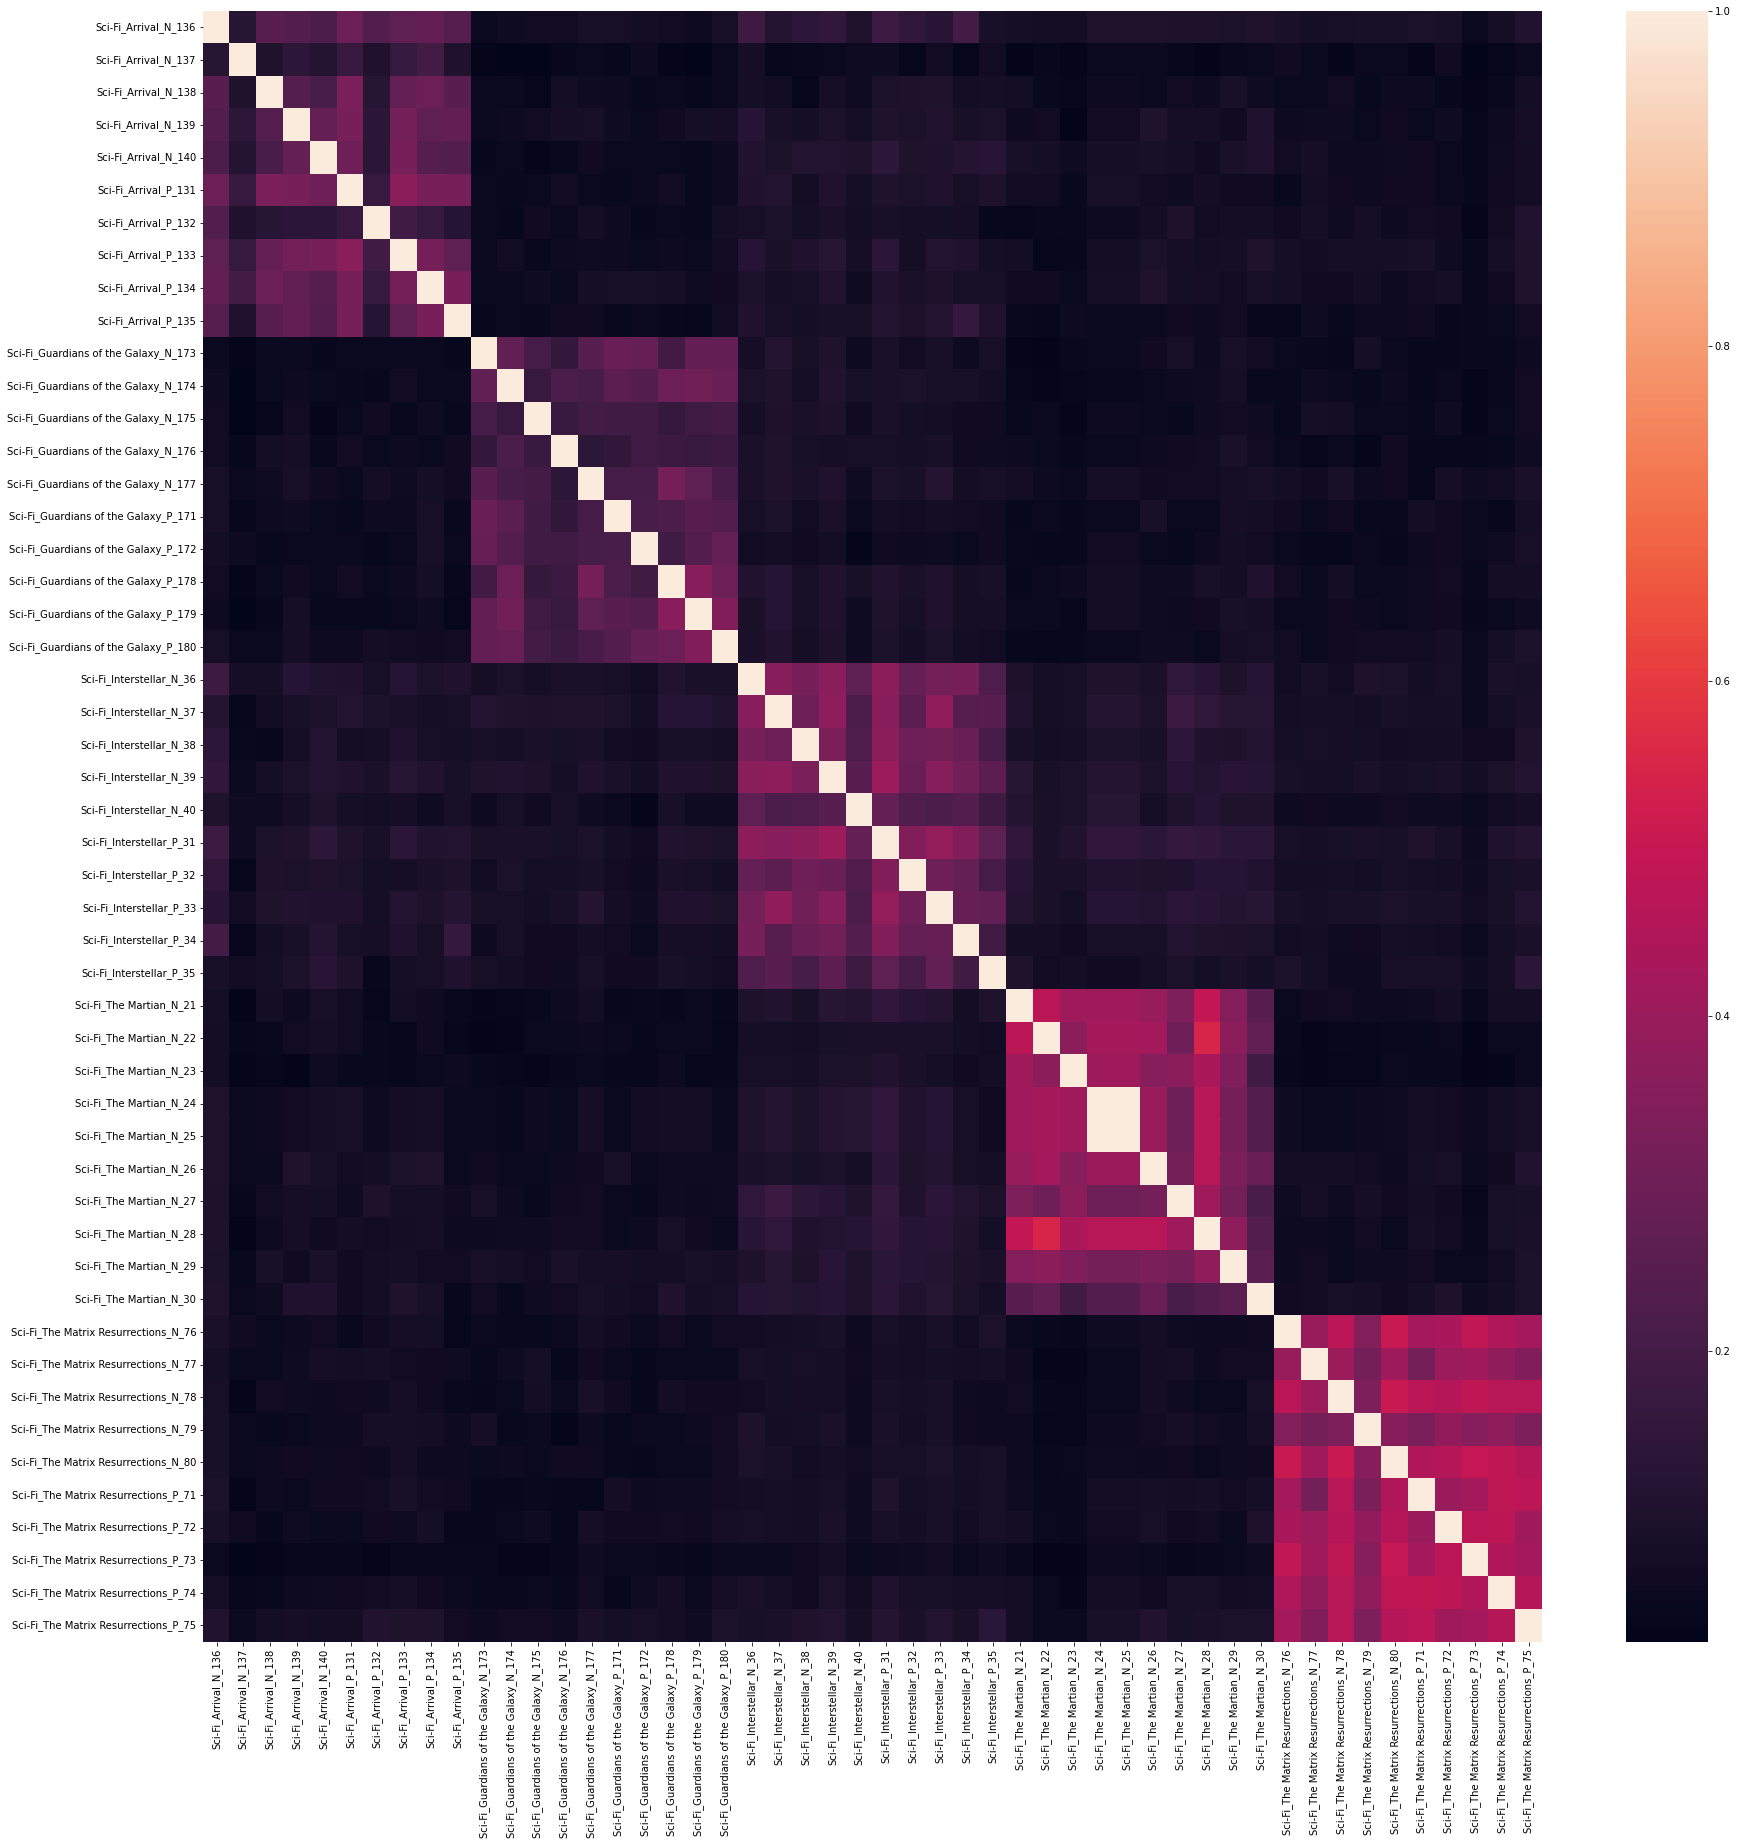

In [ ]:
run_tfidf(documents, clean_method, important_prevalent_terms, 'TFIDF_exp')

## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [ ]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]
    
    word2vec_model = Word2Vec(tokens, size=embedding_size, window=3, min_count=1, workers=12)
    
    vectors = {}
    for i in word2vec_model.wv.vocab:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result

def plot_dendrogram(data: pd.DataFrame, experiment_name: str, figsize=(30, 60)):
    plt.figure(figsize=figsize)
    plt.title("Dendrograms")  

    linkage = scipy.cluster.hierarchy.linkage(data, method='ward')
    scipy.cluster.hierarchy.dendrogram(linkage, labels=data.index, leaf_font_size=15, orientation='right')
    #plt.savefig(f'figures/{experiment_name}_dendrogram.png')
    plt.show()
    plt.close()
    
def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()
    
def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]
        
        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()
    
def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()

    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_dendrogram(filtered_word2vec_df, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [ ]:
extra_terms = [
    'interstellar',
    'nasa',
    'christopher nolan',
    'matthew mcconaughey'
]

In [ ]:
all_tokens = get_all_tokens(remove_stop_words(clean_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 - len(extra_terms)) + extra_terms

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments: 


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

In [ ]:
run_word2vec_experiment(documents, clean_method, 100, chosen_tokens, 'Word2Vec_exp')

KeyError: ignored

## Utility functions for Doc2Vec experiments

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

In [ ]:
def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)    
    
    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)
    
    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)
    
    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_dendrogram(doc2vec_df, experiment_name)
    plot_tsne(doc2vec_df, 30, experiment_name)

## Doc2Vec Experiments:

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

No handles with labels found to put in legend.


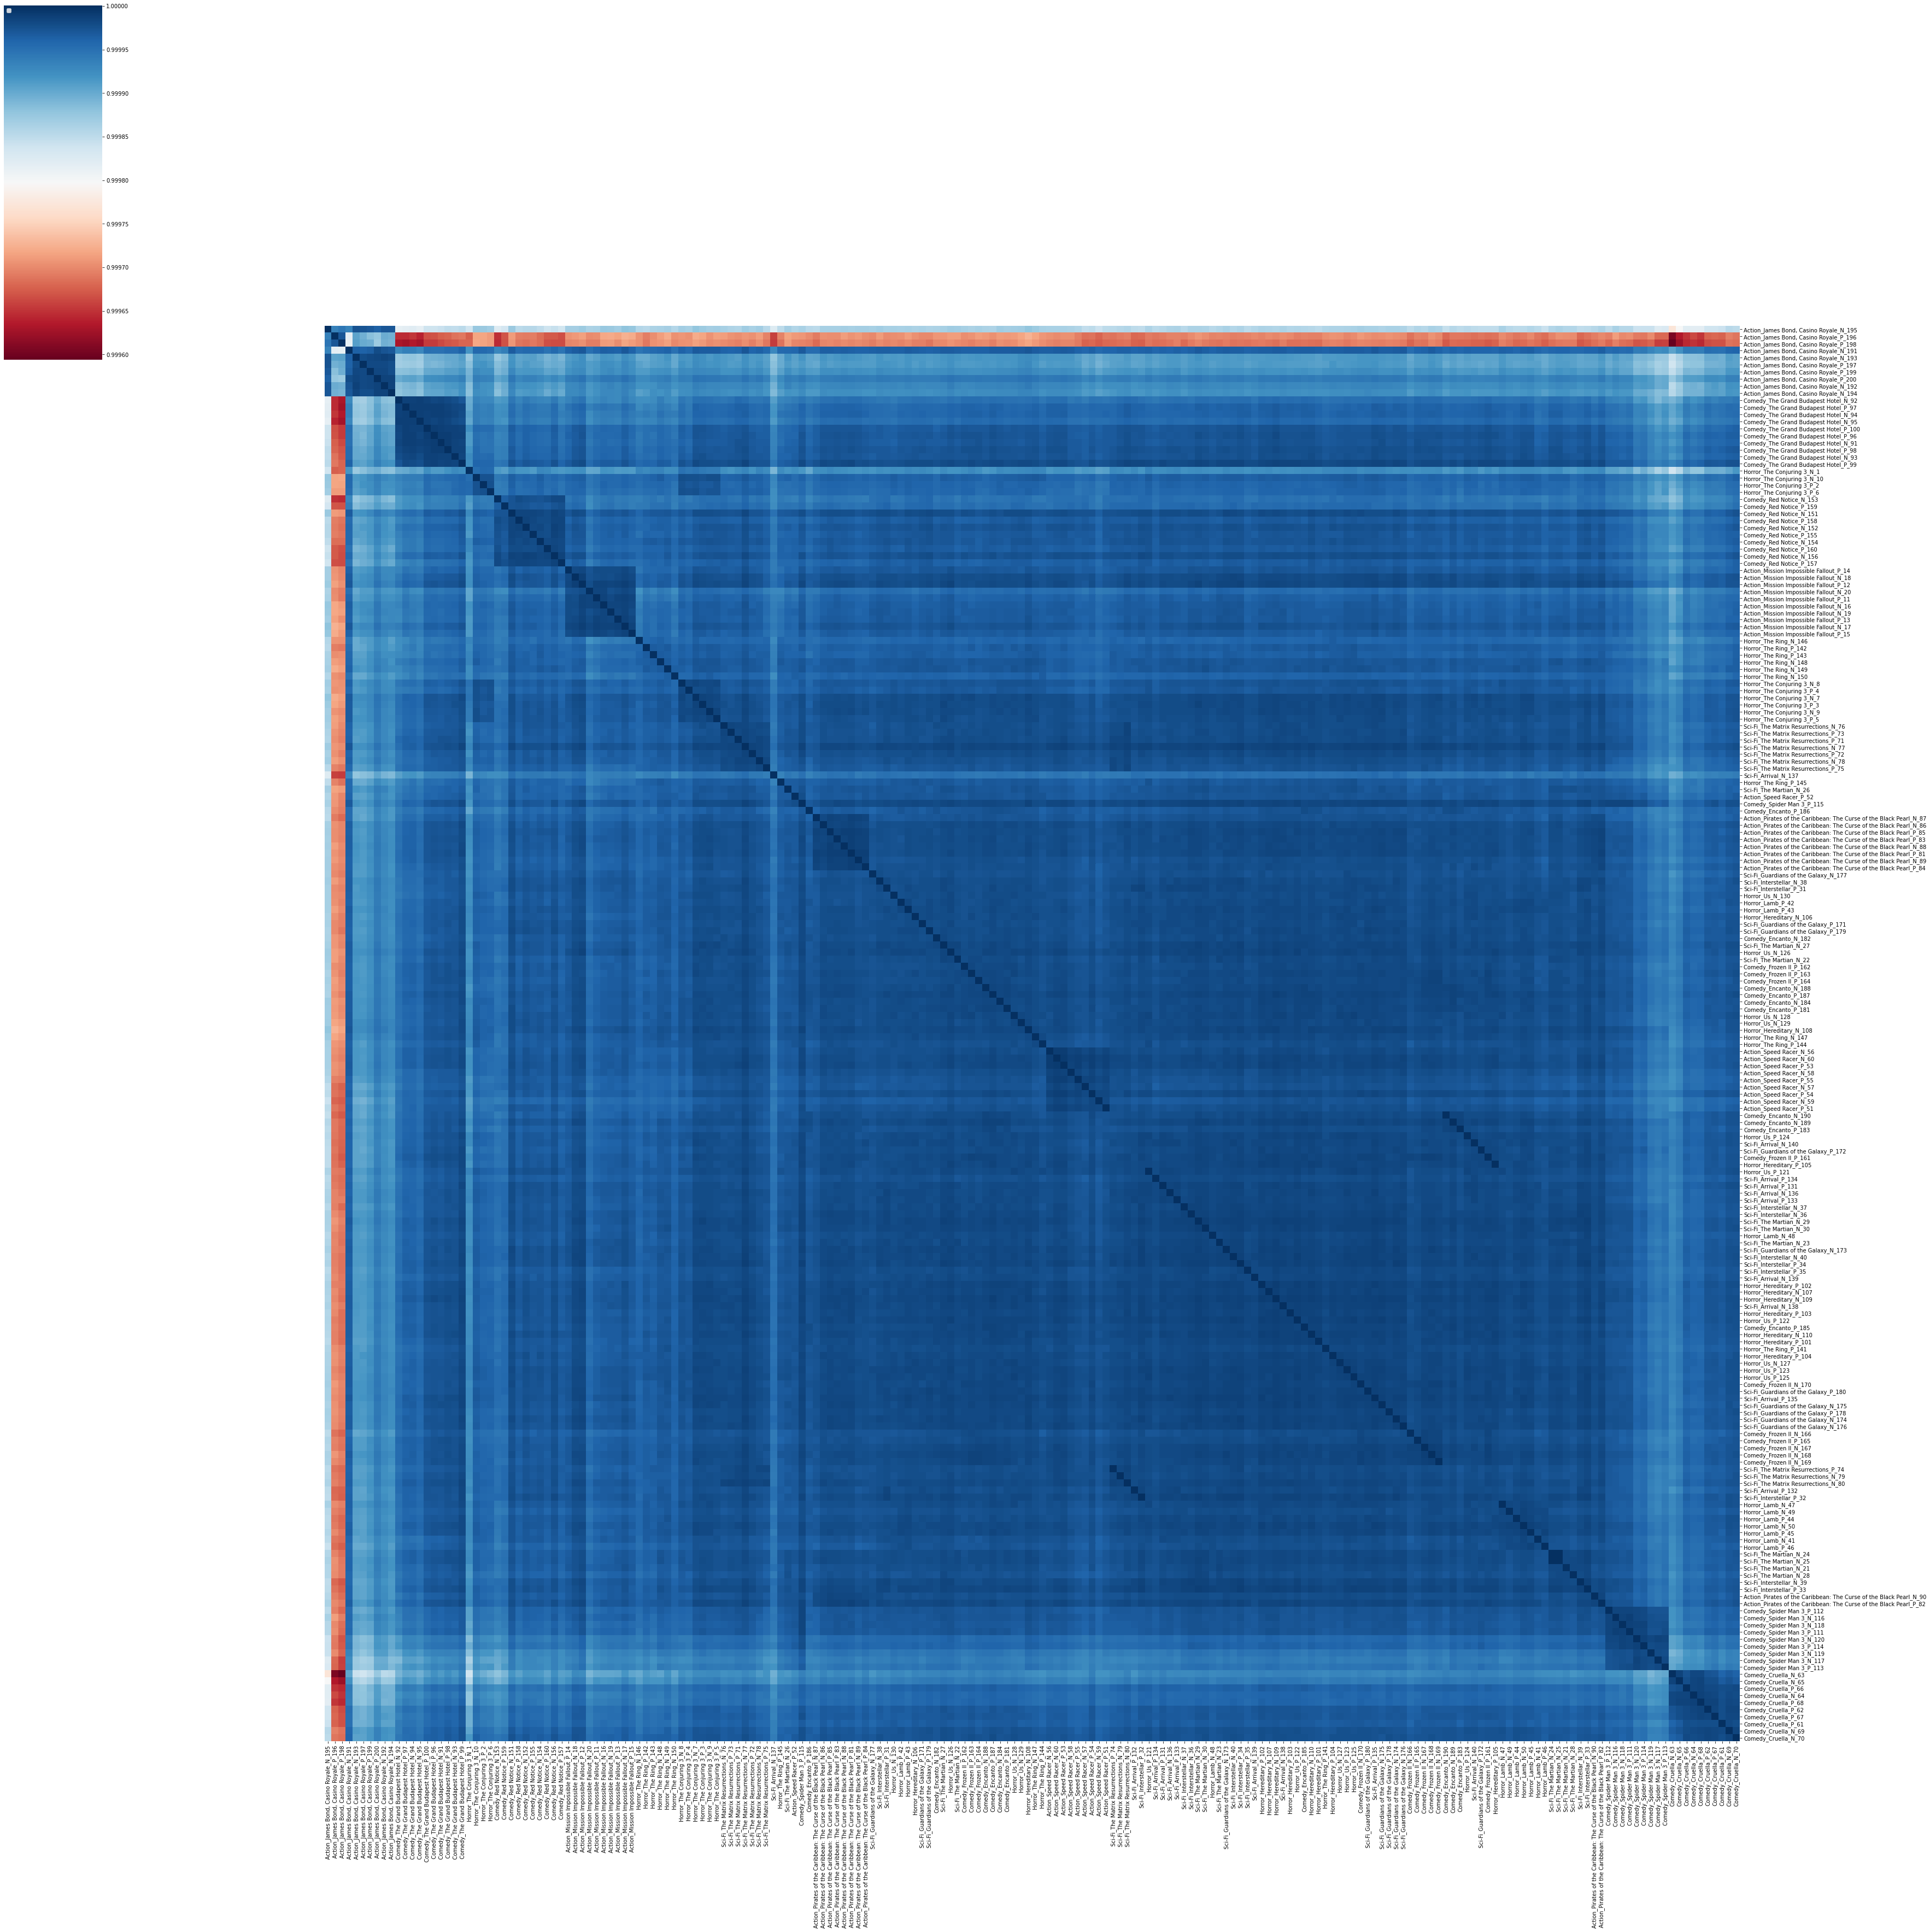

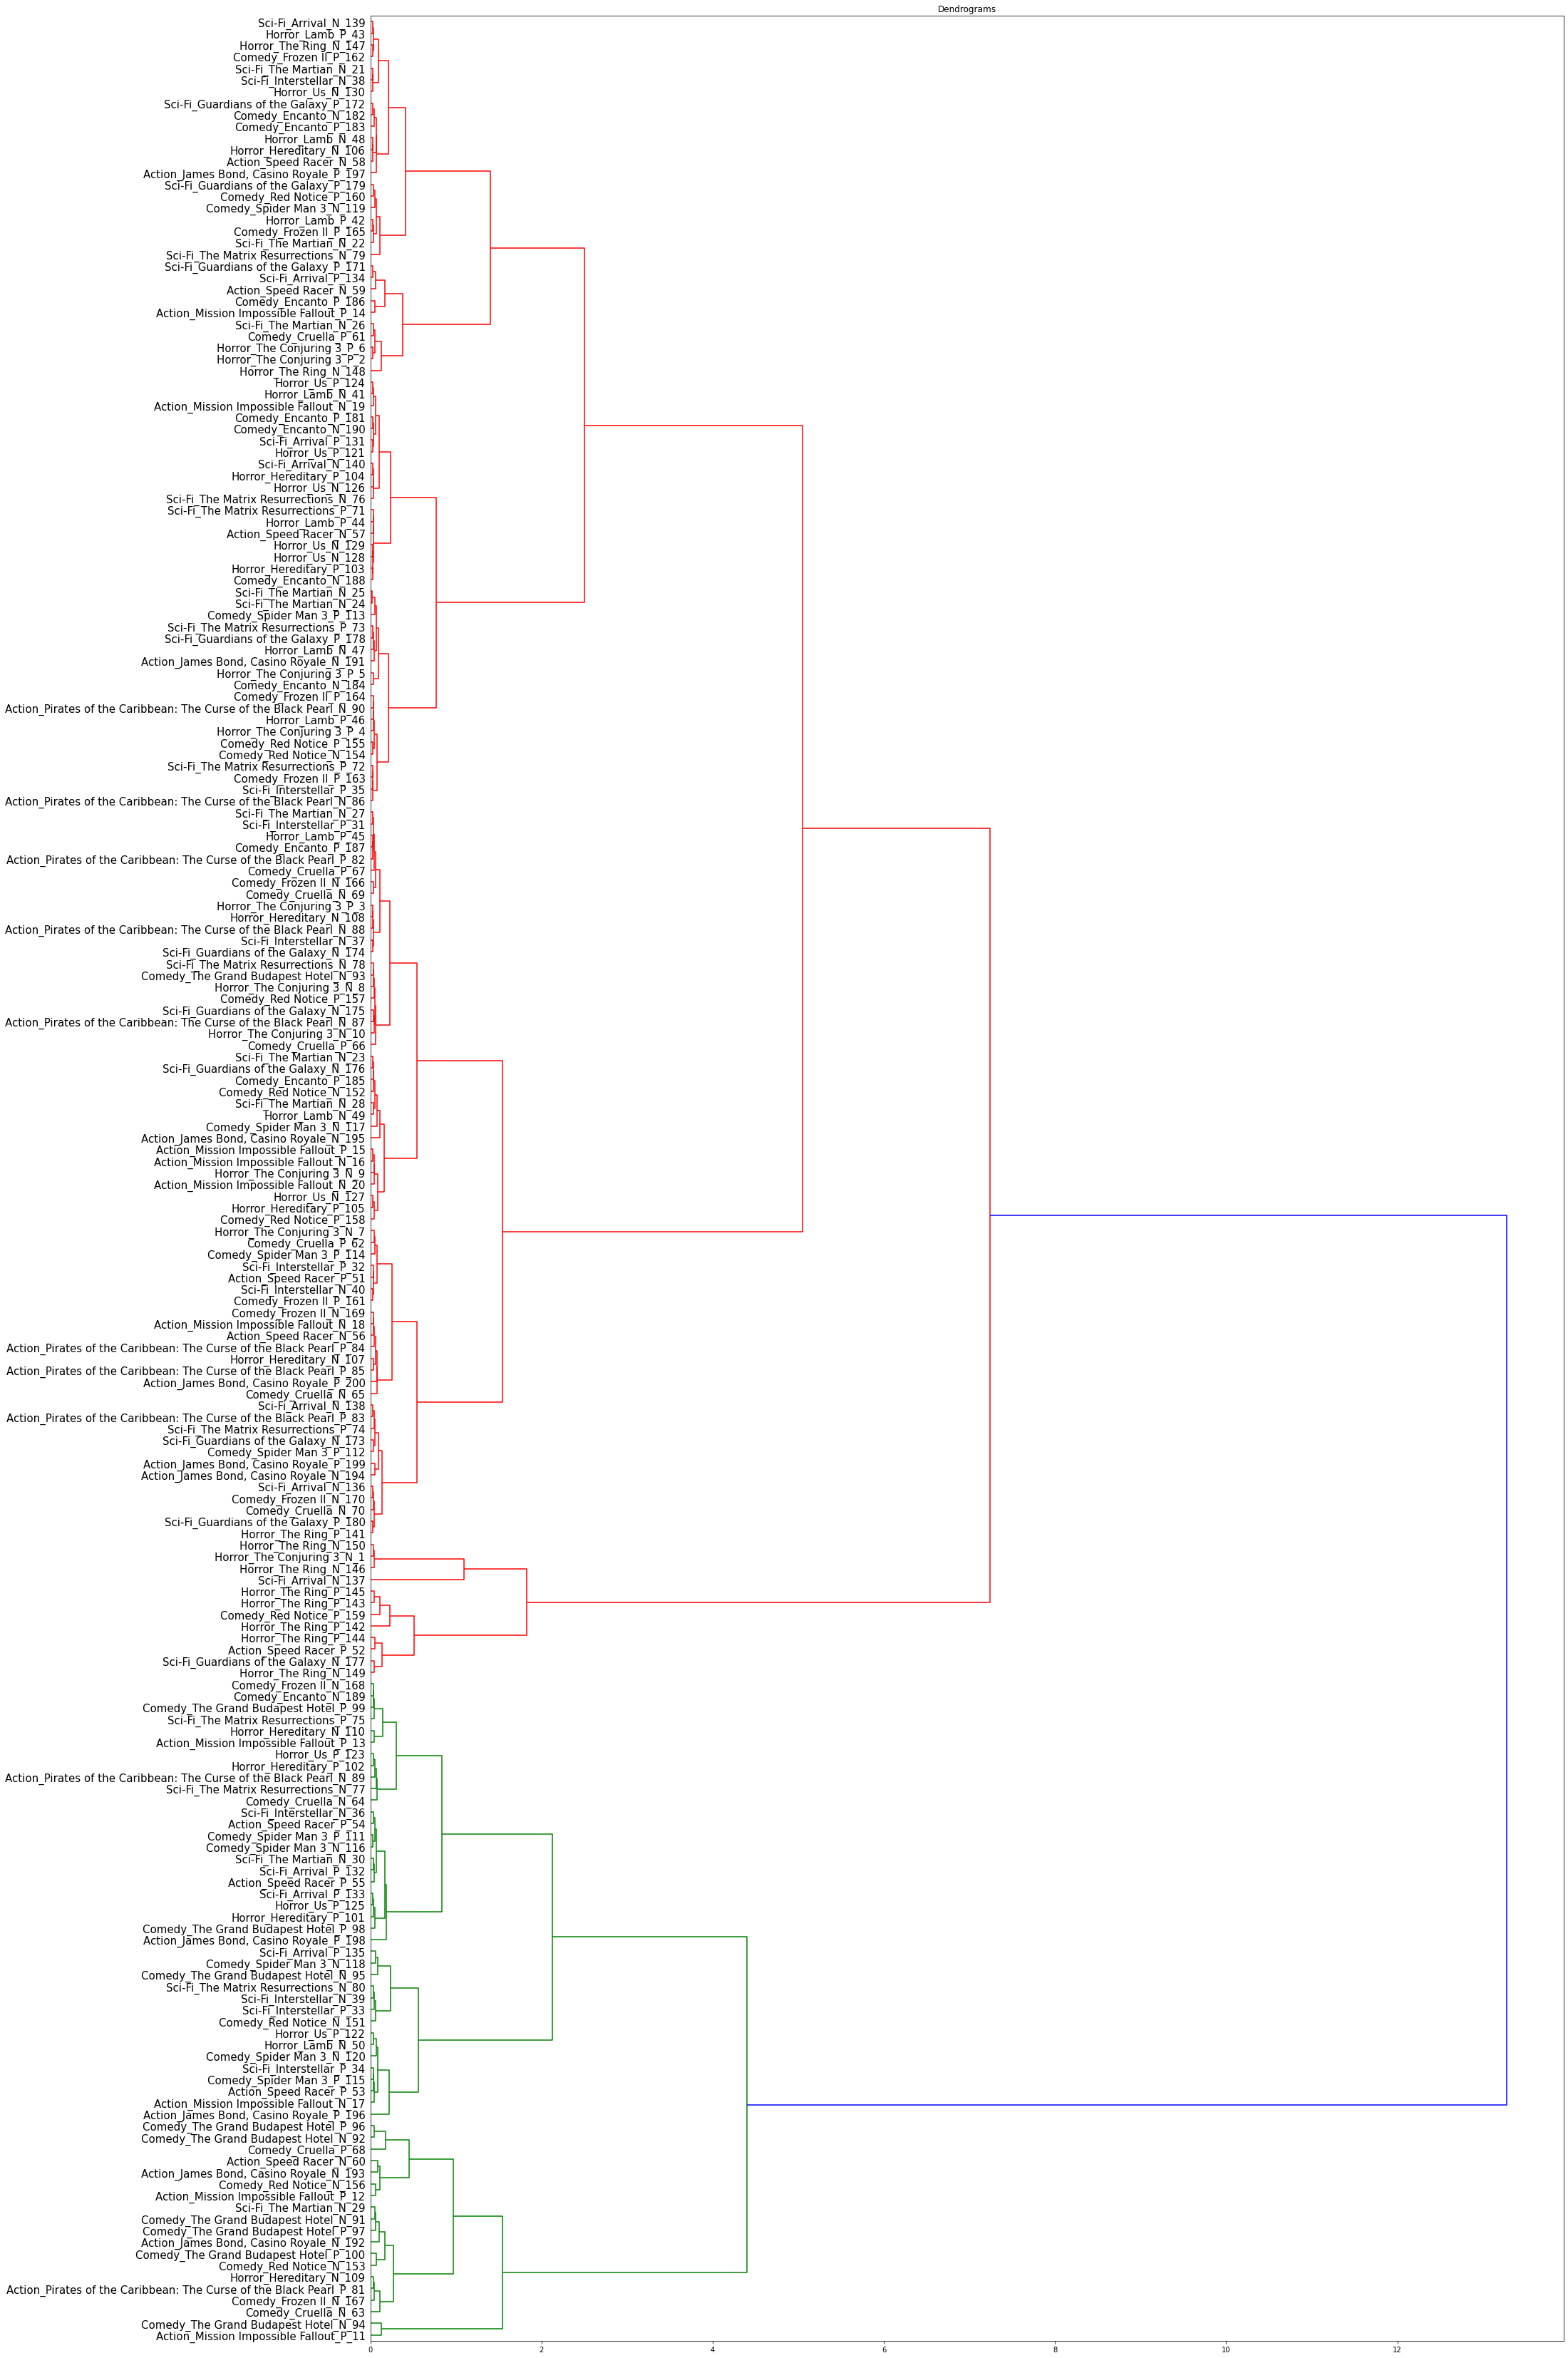

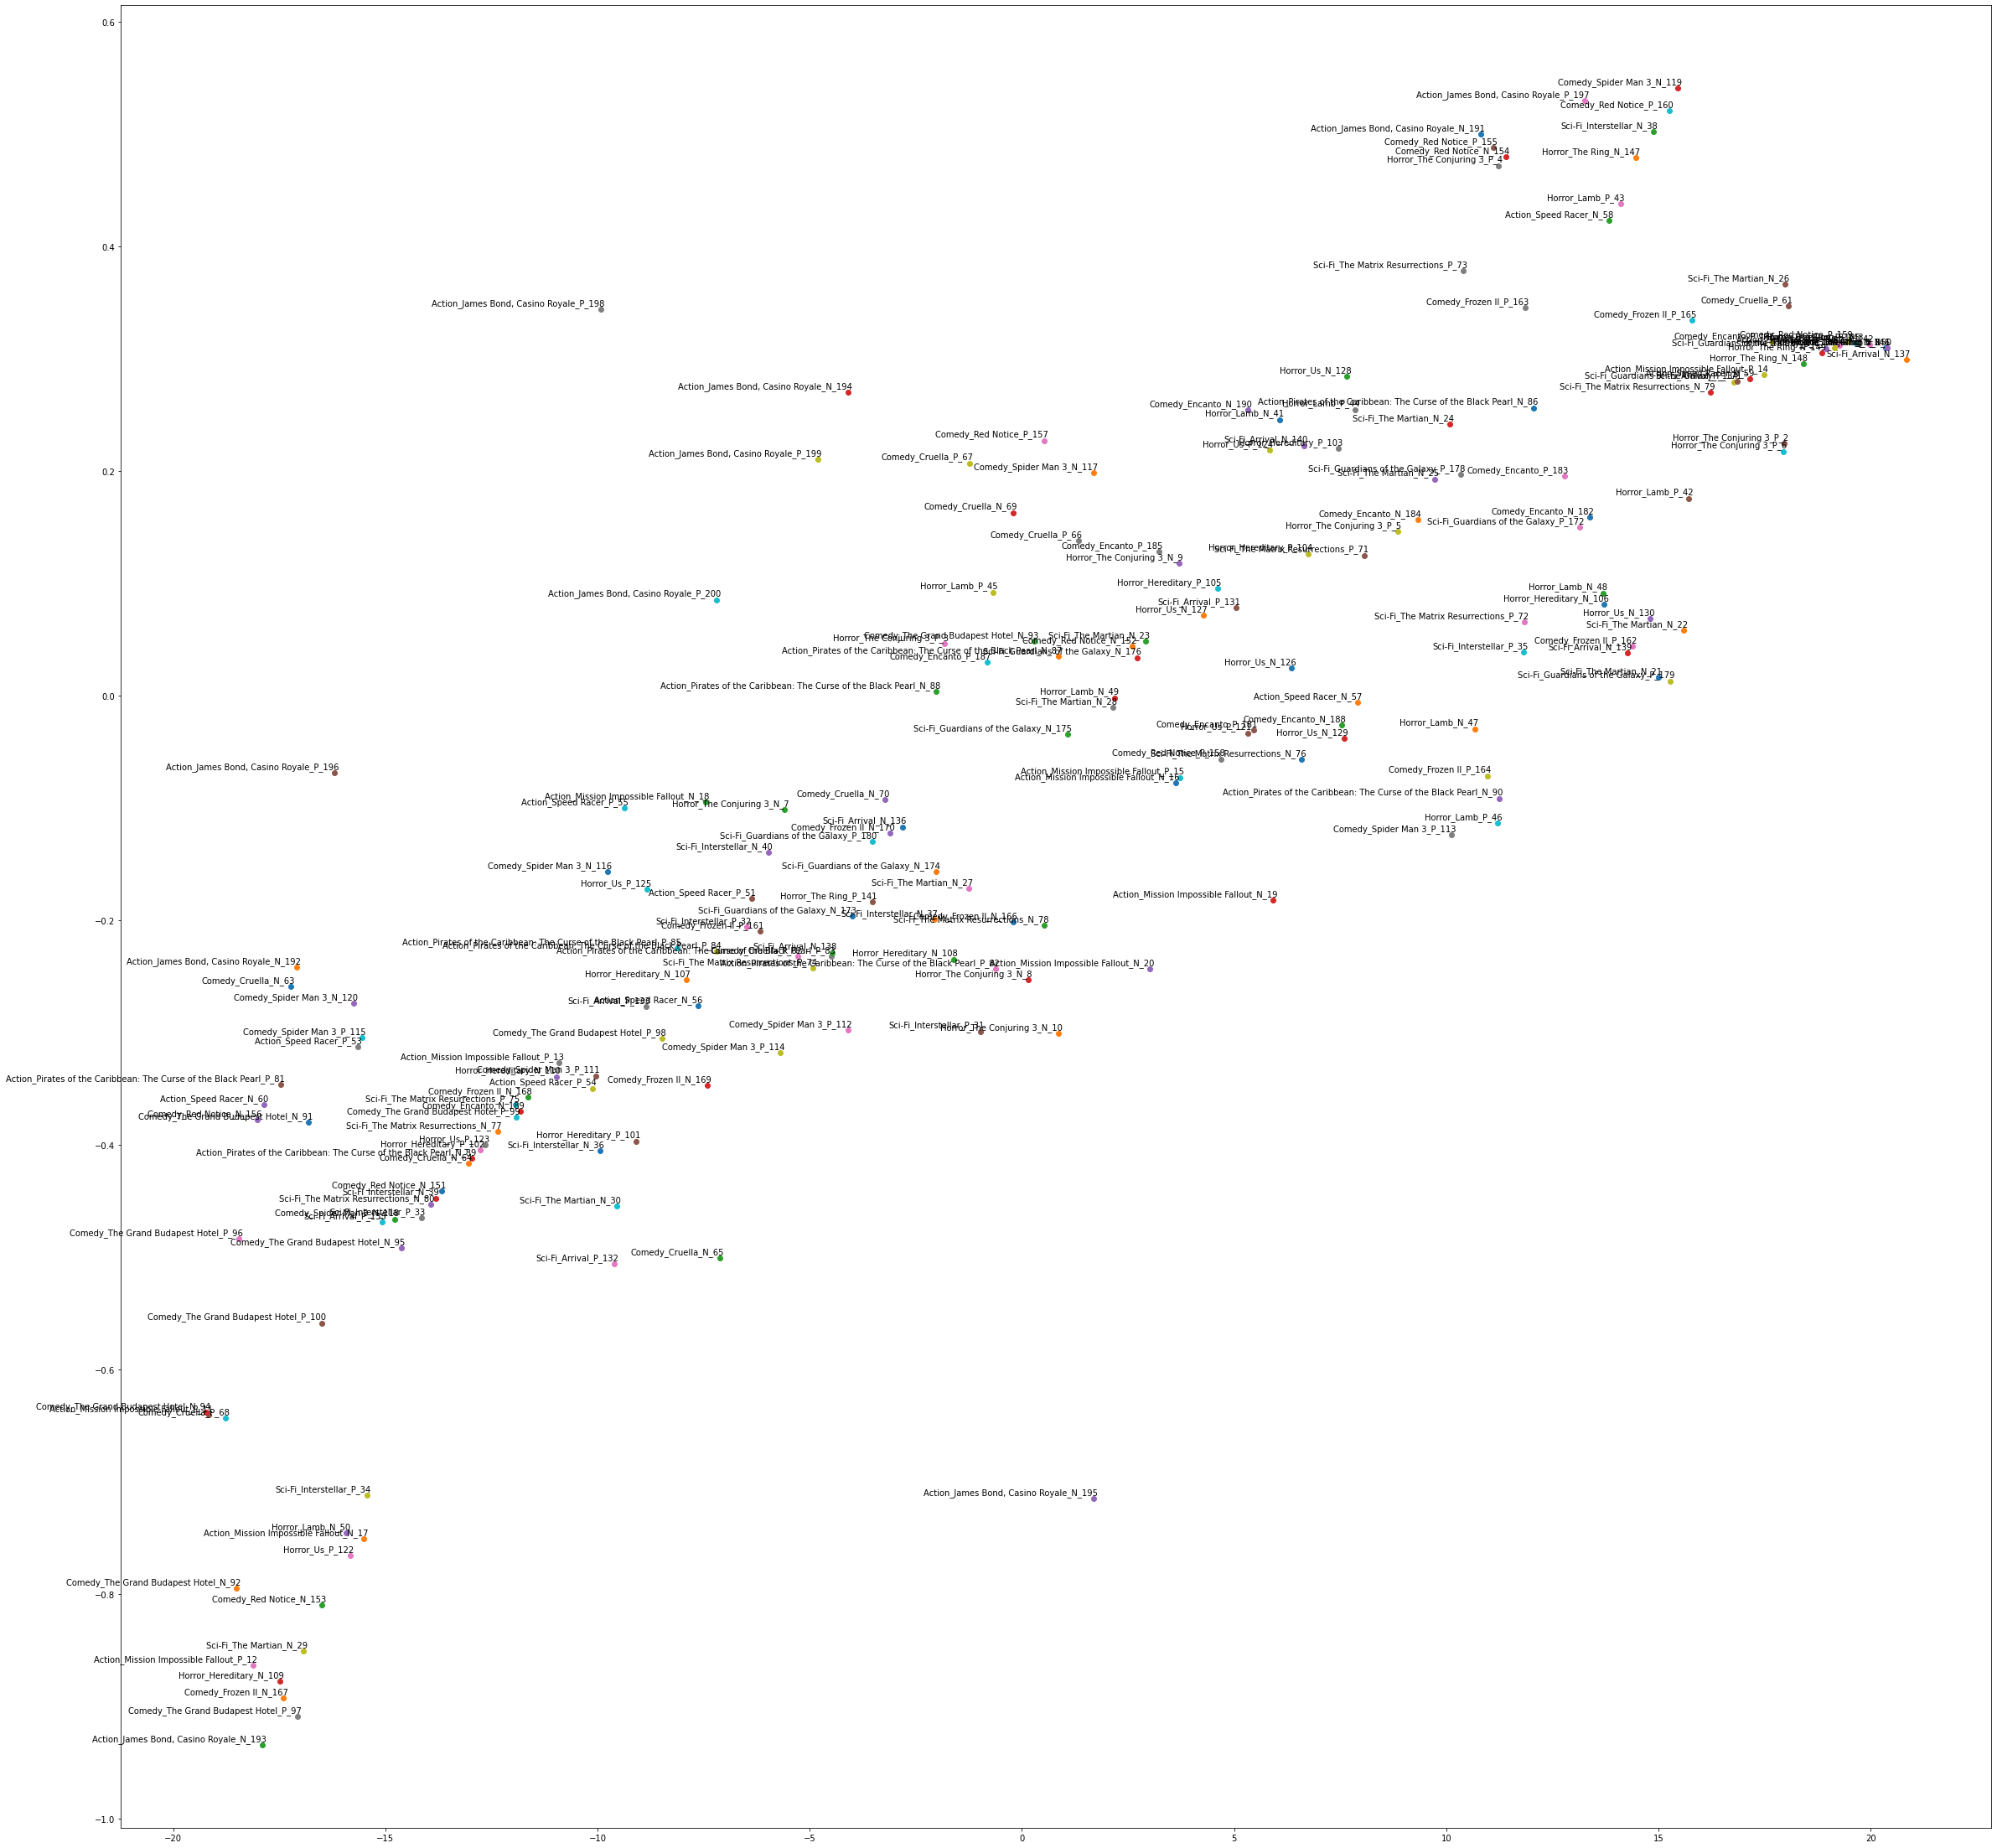

In [ ]:
run_doc2vec_experiment(documents, clean_method, 250, 'Doc2Vec_exp')